In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import grangercausalitytests
import pickle
from sklearn.model_selection import train_test_split
import re


from FRUFS import FRUFS
import matplotlib.pyplot as plt
import optuna
import joblib, gc
import lightgbm as lgb
import seaborn as sns

from sklearn.datasets import make_regression
from scipy.stats import pearsonr
from tqdm.notebook import trange, tqdm
from FRUFS import FRUFS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/home/apoletaev/miniconda3/envs/test1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Unpickling the data
infile = open("Sun_Model_Data",'rb')
Model_Data = pickle.load(infile)
infile.close()

# Reading in the data
df = Model_Data.train_x
sun_y_train = Model_Data.train_y
sun_y_test = Model_Data.test_y
sun_x_test = Model_Data.test_x


# Defining FRUFS model with k=3 maximum features
model_frufs_generated = FRUFS(
        model_r=lgb.LGBMRegressor(random_state=42),
        k=3
        #categorical_features = ["#Buys", "# Hold", "# Sell", "Total Rec"]
    )
model_frufs_generated.fit(df)
# Saving the features selected by FRUFS in a seperate dataframe 
pruned_df = model_frufs_generated.transform(df)

# Training the model on the features selected by FRUFS
frufs_model = AutoReg(sun_y_train, lags=0, exog=pruned_df).fit()
# Calculating MAE train (.sqeeze is reuired when sun_y is saved as a DF and not series)
MAE_train = np.nanmean(abs(frufs_model.predict() - sun_y_train.squeeze()))

# Saving names of the features selected by FRUFS in a list
frufs_features = list(pruned_df.columns)

# Defining test dataset with only features selected by FRUFS 
frufs_x_test = sun_x_test[frufs_features]

# Defining first and last out-of-sample indices to predict
first_oos_ind = len(sun_y_train)
last_oos_ind = first_oos_ind + len(sun_y_test) - 1

# Predicting the oos ys with the test data
y_pred_out_frufs = frufs_model.predict(start=first_oos_ind, end=last_oos_ind, exog_oos=frufs_x_test)
# Resetting index to make MAE_test calcuation possible
y_pred_out_frufs.reset_index(drop=True, inplace=True)
# Calculating MAE Test
MAE_test = np.nanmean(abs(y_pred_out_frufs - sun_y_test.squeeze()))

print(f"MAE Train = {MAE_train}; MAE_test = {MAE_test}")


Progress bar: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

MAE Train = 0.01123169220602513; MAE_test = 0.009283562848508837


In [15]:
# Unpickling the data
infile = open("Sun_Model_Data",'rb')
Model_Data = pickle.load(infile)
infile.close()

# Reading in the data
df = Model_Data.train_x
sun_y_train = Model_Data.train_y
sun_y_test = Model_Data.test_y
sun_x_test = Model_Data.test_x


# Defining FRUFS model with k=3 maximum features
model_frufs_generated = FRUFS(
        model_r=lgb.LGBMRegressor(random_state=42),
        k=8,
        n_jobs=-1
        #categorical_features = ["#Buys", "# Hold", "# Sell", "Total Rec"]
    )
model_frufs_generated.fit(df)
pruned_df = model_frufs_generated.transform(df)


Progress bar: 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


In [17]:
pruned_df

,Vol.L1,Volume.L1,Adj_Close.L2,Close.L1,Adj_Close.L1,EPS_Est_Low_NTM.L1,EPS_Est_High_NTM.L1,pc_Buy.L1
0,-0.013060,75852120.0,0.009748,-0.017873,-0.017873,0.0,0.0,0.000000
1,-0.029014,74333418.0,-0.017873,0.017029,0.017029,0.0,0.0,-0.034686
2,0.001343,84596680.0,0.017029,-0.020039,-0.020039,0.0,0.0,0.000000
3,-0.009552,71576300.0,-0.020039,0.000000,0.000000,0.0,0.0,0.000000
4,0.002705,73839528.0,0.000000,0.011774,0.011774,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
1574,-0.016196,63769340.0,0.005163,-0.005163,-0.005163,0.0,0.0,0.000000
1575,0.022635,71966790.0,-0.005163,0.029076,0.029076,0.0,0.0,0.000000
1576,-0.002957,49288230.0,0.029076,-0.007064,-0.007064,0.0,0.0,0.000000
1577,-0.018237,54544880.0,-0.007064,0.015574,0.015574,0.0,0.0,0.000000


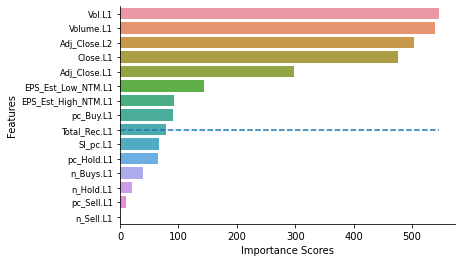

In [16]:
model_frufs_generated.feature_importance()

In [ ]:
# set up logging to console
console = logging.StreamHandler()
console.setLevel(logging.DEBUG)
# set a format which is simpler for console use
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
console.setFormatter(formatter)
# add the handler to the root logger
logging.getLogger('').addHandler(console)

logger = logging.getLogger(__name__)

Progress bar: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


MAE Train = 0.008891410570805806; MAE_test = 0.016047933048926034


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]


MAE Train = 0.008890235259406125; MAE_test = 0.016033701064396715


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


MAE Train = 0.008862585554020676; MAE_test = 0.015963287999108063


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s]


MAE Train = 0.008847628000370134; MAE_test = 0.015975040039406377


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  4.79it/s]


MAE Train = 0.00884773869633702; MAE_test = 0.016011440807608697


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  5.13it/s]


MAE Train = 0.008844584879933717; MAE_test = 0.0160126435834811


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


MAE Train = 0.008845686859131717; MAE_test = 0.016003824545759802


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  4.96it/s]


MAE Train = 0.008845763877896082; MAE_test = 0.016007546132967794


Progress bar: 100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


MAE Train = 0.008846606011146224; MAE_test = 0.015992434633212052


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  4.36it/s]


MAE Train = 0.008846606011146223; MAE_test = 0.015992434633212052


Progress bar: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


MAE Train = 0.008849003970706175; MAE_test = 0.01598787358039286


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  4.41it/s]


MAE Train = 0.00884707278881595; MAE_test = 0.015993613000512573


Progress bar: 100%|██████████| 13/13 [00:02<00:00,  4.79it/s]


MAE Train = 0.008838770387786448; MAE_test = 0.016040049943085232


<AxesSubplot:xlabel='Feature %', ylabel='value'>

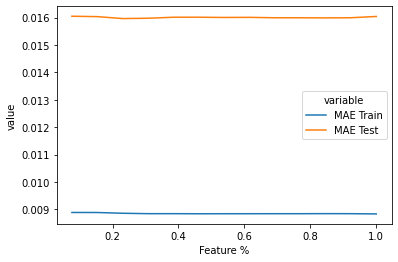

In [3]:
# Unpickling the data
infile = open("Sun_Model_Data",'rb')
Model_Data = pickle.load(infile)
infile.close()

# Reading in the data
sun_x_train = Model_Data.train_x
sun_y_train = Model_Data.train_y
sun_y_test = Model_Data.test_y
sun_x_test = Model_Data.test_x

total_n_features = len(list(sun_x_train.columns))
FRUFS_Loop = {"MAE Train":[], "MAE Test":[], "Feature %":[]}

for n in list(range(1, total_n_features+1)):
    # Defining FRUFS model with k=3 maximum features
    model_frufs_generated = FRUFS(
            model_r=lgb.LGBMRegressor(random_state=42),
            k=n
            #categorical_features = ["#Buys", "# Hold", "# Sell", "Total Rec"]
        )
    model_frufs_generated.fit(sun_x_train)
    # Saving the features selected by FRUFS in a seperate dataframe 
    pruned_df = model_frufs_generated.transform(sun_x_train)

    # Training the model on the features selected by FRUFS
    frufs_model = AutoReg(sun_y_train, lags=0, exog=pruned_df).fit()
    # Calculating MAE train (.sqeeze is reuired when sun_y is saved as a DF and not series)
    MAE_train = np.nanmean(abs(frufs_model.predict() - sun_y_train.squeeze()))

    # Saving names of the features selected by FRUFS in a list
    frufs_features = list(pruned_df.columns)

    # Defining test dataset with only features selected by FRUFS 
    frufs_x_test = sun_x_test[frufs_features]

    # Defining first and last out-of-sample indices to predict
    first_oos_ind = len(sun_y_train)
    last_oos_ind = first_oos_ind + len(sun_y_test) - 1

    # Predicting the oos ys with the test data
    y_pred_out_frufs = frufs_model.predict(start=first_oos_ind, end=last_oos_ind, exog_oos=frufs_x_test)
    # Resetting index to make MAE_test calcuation possible
    y_pred_out_frufs.reset_index(drop=True, inplace=True)
    # Calculating MAE Test
    MAE_test = np.nanmean(abs(y_pred_out_frufs - sun_y_test.squeeze()))

    print(f"MAE Train = {MAE_train}; MAE_test = {MAE_test}")
    # Feature_pc = round(n/total_n_features, sigfigs=3)

    FRUFS_Loop["MAE Train"].append(MAE_train)
    FRUFS_Loop["MAE Test"].append(MAE_test)
    FRUFS_Loop["Feature %"].append(n/total_n_features)


FRUFS_Loop = pd.DataFrame.from_dict(FRUFS_Loop)
sns.lineplot(x='Feature %', y='value', hue='variable', 
             data=pd.melt(FRUFS_Loop, ['Feature %']))
